In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier   
from lightgbm import LGBMClassifier
import joblib

In [3]:
import kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

d:\AI\Cybersoft\Projects\Random_Forrest\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("Path to dataset:", path)
#read dataset
data = pd.read_csv(path + '/creditcard.csv')
#explore dataset
print(data.head())
print(data.info())
print(data.describe())
print(data["Class"].value_counts())

Path to dataset: C:\Users\Victus\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.8177

In [5]:
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

In [6]:
X = data.drop(columns=["Class"])
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [7]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

best_model = None
best_accuracy = 0
results = {}

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    #dump the model to models folder
    joblib.dump(model, f'models/{model_name.replace(" ", "_").lower()}_model.pkl')

    y_pred = model.predict(X_test)
    accuracy = (y_pred == y_test).mean()
    results[model_name] = accuracy
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

if best_model:
    joblib.dump(best_model, 'best_fraud_detection_model.pkl')
    print("Best model saved as 'best_fraud_detection_model.pkl'")

Model: Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.42      0.79      0.55        98

    accuracy                           1.00     56962
   macro avg       0.71      0.89      0.77     56962
weighted avg       1.00      1.00      1.00     56962

Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



d:\AI\Cybersoft\Projects\Random_Forrest\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:33:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.87      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model: LightGBM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.86      0.71        98

    accuracy                        

In [8]:
best_model

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


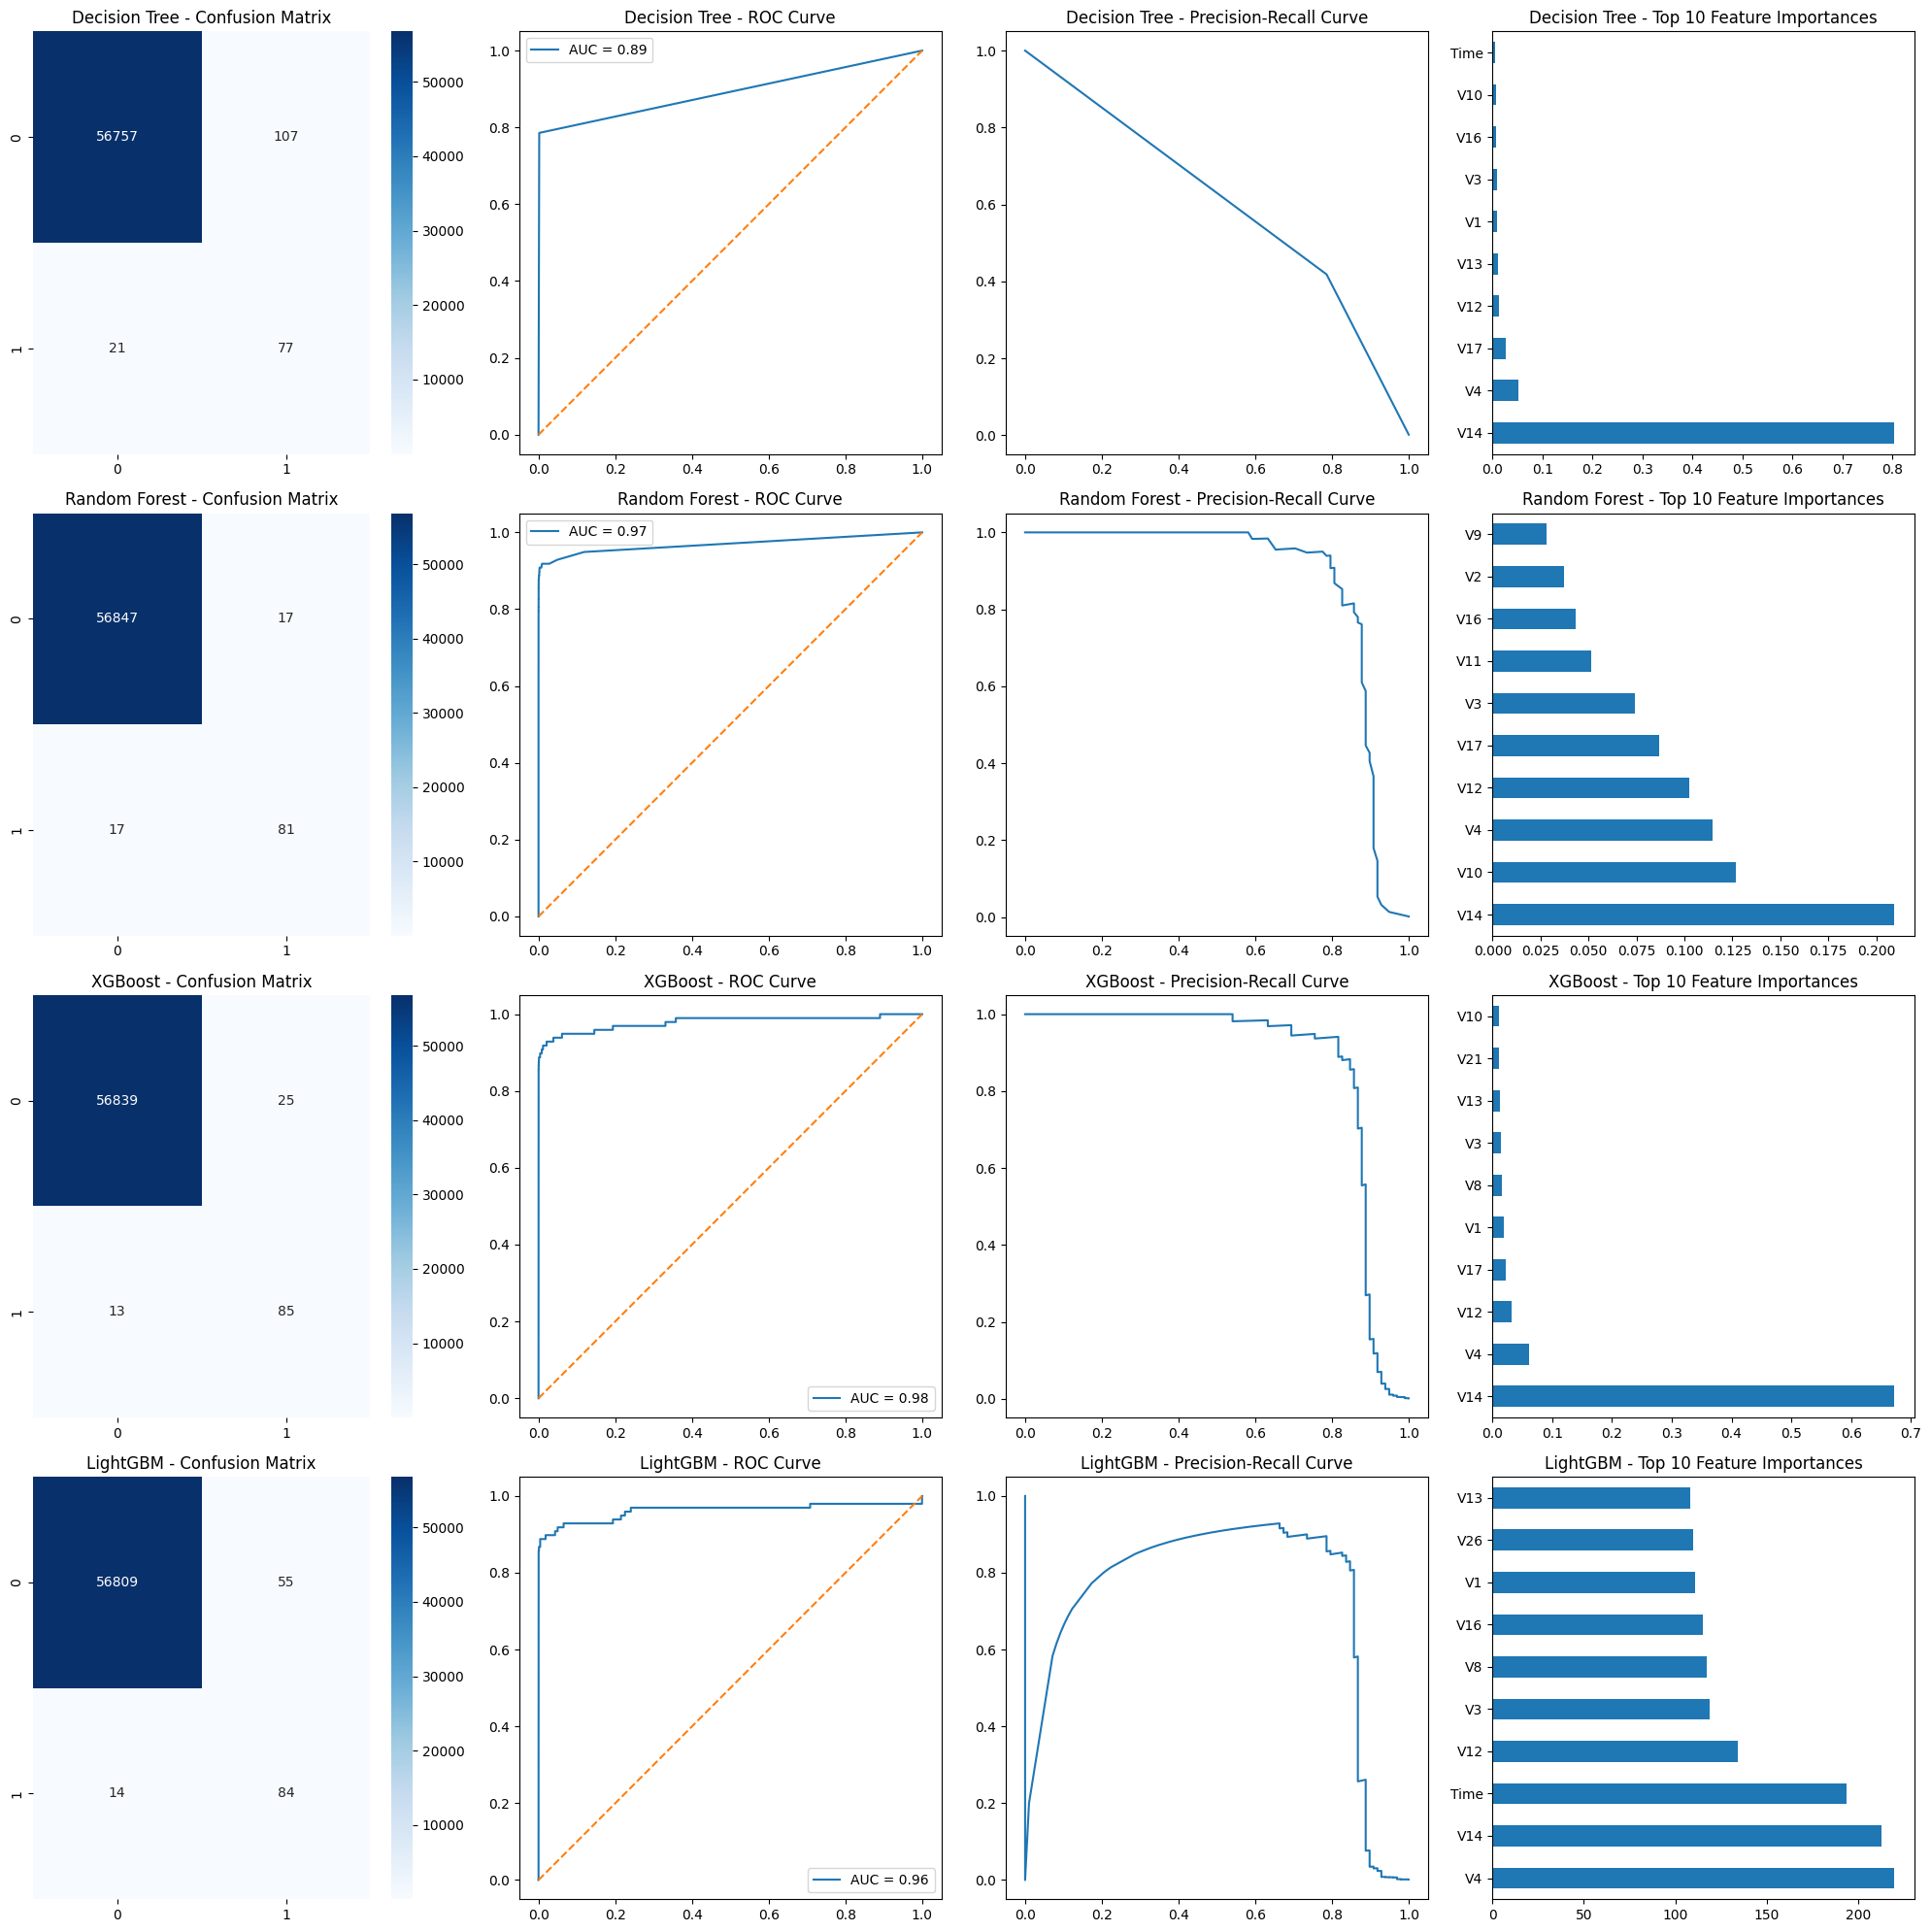

In [17]:
n_models = len(models)
fig, axes = plt.subplots(n_models, 4, figsize=(20, 5 * n_models))

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Flatten axes for easy indexing
    ax_cm, ax_roc, ax_pr, ax_fi = axes[i] if n_models > 1 else axes

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_title(f'{model_name} - Confusion Matrix')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax_roc.plot([0,1],[0,1],'--')
    ax_roc.set_title(f'{model_name} - ROC Curve')
    ax_roc.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ax_pr.plot(recall, precision)
    ax_pr.set_title(f'{model_name} - Precision-Recall Curve')

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        feature_importances.nlargest(10).plot(kind='barh', ax=ax_fi)
        ax_fi.set_title(f'{model_name} - Top 10 Feature Importances')

plt.tight_layout()
plt.show()
